# 字体数字分类

## 创建随机字体数字图片

In [18]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw 

In [19]:
import torch 

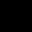

In [20]:
img = np.zeros((32,32,3), dtype=np.uint8)
Image.fromarray(img)

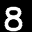

In [263]:

def get_img(text, nums=1, shape=(32,32,3)):
    # img = np.random.randint(0, 255, shape, dtype=np.uint8)
    img = np.zeros(shape, dtype=np.uint8)
    img = cv2.putText(img, f"{text}", (3, shape[1] - 3), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return img 

Image.fromarray(get_img(8))

## 创建数据

In [24]:
import random 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader


In [253]:
class FontNumberDataset(Dataset):
    def __init__(self, length=60000):
        self.length = length
    
    def __len__(self):
        return self.length 
    
    def __getitem__(self, idx):
        label = random.randint(0, 9)
        img = get_img(label)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = torch.Tensor(gray)
        gray = gray.gray = gray.unsqueeze(0)
        return gray, label


In [249]:
gray = torch.Tensor(np.random.randint(0, 255, (10,10)))
gray = gray.unsqueeze(0)
gray.shape

torch.Size([1, 10, 10])

In [254]:

train_dataloader = DataLoader(FontNumberDataset(), batch_size=64, shuffle=True)
test_dataloader = DataLoader(FontNumberDataset(), batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 32, 32])
Labels batch shape: torch.Size([64])


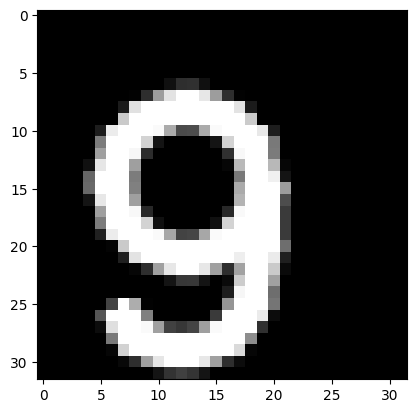

Label: 9


In [266]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 创建PyTorch模型

In [28]:
import torch
from torch import nn
from torchvision.transforms import ToTensor

In [246]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class LeNet5(nn.Module):
    def __init__(self, num_classes=-1):
        super(LeNet5, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1), nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1), nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1), nn.Tanh())
        if self.num_classes > 0:
            self.classifier = nn.Sequential(
                nn.Linear(120, 84),
                nn.Tanh(),
                nn.Linear(84, num_classes),
            )

    def forward(self, x):

        x = self.features(x)
        if self.num_classes > 0:
            x = self.classifier(x.squeeze())

        return x




model = LeNet5(10).to(device)
print(model)

Using cuda device
LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


## 创建优化器

In [224]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 训练模型

In [227]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [226]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [267]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306608  [   64/60000]
loss: 2.316438  [ 6464/60000]
loss: 2.319332  [12864/60000]
loss: 2.311575  [19264/60000]
loss: 2.329077  [25664/60000]
loss: 2.306381  [32064/60000]
loss: 2.321919  [38464/60000]
loss: 2.330587  [44864/60000]
loss: 2.323778  [51264/60000]
loss: 2.309835  [57664/60000]
Test Error: 
 Accuracy: 9.9%, Avg loss: 2.320163 

Epoch 2
-------------------------------
loss: 2.326779  [   64/60000]
loss: 2.313706  [ 6464/60000]
loss: 2.337355  [12864/60000]
loss: 2.317734  [19264/60000]
loss: 2.334779  [25664/60000]
loss: 2.306442  [32064/60000]
loss: 2.330477  [38464/60000]
loss: 2.313225  [44864/60000]
loss: 2.323377  [51264/60000]
loss: 2.317936  [57664/60000]
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.319780 

Epoch 3
-------------------------------
loss: 2.322984  [   64/60000]
loss: 2.319089  [ 6464/60000]
loss: 2.345253  [12864/60000]
loss: 2.301015  [19264/60000]
loss: 2.313772  [25664/60000]
loss: 2.300312  [32064/6000

## 保存模型

## Saving Models

In [34]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [35]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## 模型评价

In [36]:
for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    print(X.shape, X.dtype, X.device)
    model.to(device)
    model(X)
    break 

torch.Size([64, 28, 28]) torch.float32 cuda:0


In [282]:
img = get_img(2)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x = torch.from_numpy(np.array(gray, dtype=np.float32))
x = x.unsqueeze(0).unsqueeze(0)

model.eval()


x = x.to(device)
model = model.to(device)
print(x.shape, x.dtype, x.device)

with torch.no_grad():
    pred = model(x)
    print(pred)
    print(pred.argmax(0))

# with torch.no_grad():
#     pred = model(x)
#     predicted, actual = classes[pred[0].argmax(0)], classes[y]
#     print(f'Predicted: "{predicted}", Actual: "{actual}"')

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32]) torch.float32 cuda:0
tensor([-0.1024,  0.0019,  0.1228, -0.0972,  0.0768, -0.0446,  0.0355,  0.0413,
        -0.1128, -0.1799], device='cuda:0')
tensor(2, device='cuda:0')


In [285]:
tdata = DataLoader(FontNumberDataset(4), batch_size=2, shuffle=True)

for batch, (X, y) in enumerate(tdata):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    print(pred, y)

    print(pred.argmax(1) == y)


tensor([[-0.0473, -0.0488,  0.1077, -0.0645,  0.0251, -0.0322,  0.0493, -0.0204,
         -0.0721, -0.0746],
        [-0.0473, -0.0488,  0.1077, -0.0645,  0.0251, -0.0322,  0.0493, -0.0204,
         -0.0721, -0.0746]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([1, 1], device='cuda:0')
tensor([False, False], device='cuda:0')
tensor([[-0.1556,  0.0293,  0.0783, -0.1258,  0.1074, -0.0619,  0.0322,  0.0994,
         -0.1469, -0.1915],
        [-0.1024,  0.0019,  0.1228, -0.0972,  0.0768, -0.0446,  0.0355,  0.0413,
         -0.1128, -0.1799]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([9, 2], device='cuda:0')
tensor([False,  True], device='cuda:0')
